# Chapter 6: 機械学習

本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

## 50. データの入手・整形

News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．

学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip -P ../data/

--2020-11-02 12:15:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘../data/NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  13.8MB/s    in 2.0s    

2020-11-02 12:15:24 (13.8 MB/s) - ‘../data/NewsAggregatorDataset.zip’ saved [29224203/29224203]



In [5]:
!unzip ../data/NewsAggregatorDataset.zip -d ../data/news_aggregator

Archive:  ../data/NewsAggregatorDataset.zip
  inflating: ../data/news_aggregator/2pageSessions.csv  
   creating: ../data/news_aggregator/__MACOSX/
  inflating: ../data/news_aggregator/__MACOSX/._2pageSessions.csv  
  inflating: ../data/news_aggregator/newsCorpora.csv  
  inflating: ../data/news_aggregator/__MACOSX/._newsCorpora.csv  
  inflating: ../data/news_aggregator/readme.txt  
  inflating: ../data/news_aggregator/__MACOSX/._readme.txt  


In [6]:
!cat ../data/news_aggregator/readme.txt

SUMMARY: Dataset of references (urls) to news web pages

DESCRIPTION: Dataset of references to news web pages collected from an online aggregator in the period from March 10 to August 10 of 2014. The resources are grouped into clusters that represent pages discussing the same news story. The dataset includes also references to web pages that point (has a link to) one of the news page in the collection.

TAGS: web pages, news, aggregator, classification, clustering

LICENSE: Public domain - Due to restrictions on content and use of the news sources, the corpus is limited to web references (urls) to web pages and does not include any text content. The references have been retrieved from the news aggregator through traditional web browsers. 

FILE ENCODING: UTF-8

FORMAT: Tab delimited CSV files. 

DATA SHAPE AND STATS: 422937 news pages and divided up into:

152746 	news of business category
108465 	news of science and technology category
115920 	news of business category
 45615 	news of

In [7]:
import pandas as pd

In [8]:
df = pd.read_table('../data/news_aggregator/newsCorpora.csv', header=None)

In [9]:
df.columns = ['id', 'title', 'url', 'publisher', 'category', 'story', 'hostname', 'timestamp']

In [10]:
news_df = df[df['publisher'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]

In [11]:
news_df = news_df.sample(frac=1)

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_df, test_df = train_test_split(news_df, test_size=.2, random_state=1)

In [14]:
test_df, val_df = train_test_split(test_df, test_size=.5, random_state=1)

In [15]:
train_df.to_csv('../data/news_aggregator/train.txt', sep='\t', index=False)

In [16]:
val_df.to_csv('../data/news_aggregator/valid.txt', sep='\t', index=False)

In [17]:
test_df.to_csv('../data/news_aggregator/test.txt', sep='\t', index=False)

In [18]:
train_df.groupby('category').count()

,id,title,url,publisher,story,hostname,timestamp
category,,,,,,,
b,4522,4522,4522,4522,4522,4522,4522
e,4209,4209,4209,4209,4209,4209,4209
m,714,714,714,714,714,714,714
t,1227,1227,1227,1227,1227,1227,1227


In [19]:
test_df.groupby('category').count()

,id,title,url,publisher,story,hostname,timestamp
category,,,,,,,
b,527,527,527,527,527,527,527
e,554,554,554,554,554,554,554
m,101,101,101,101,101,101,101
t,152,152,152,152,152,152,152


In [20]:
val_df.groupby('category').count()

,id,title,url,publisher,story,hostname,timestamp
category,,,,,,,
b,578,578,578,578,578,578,578
e,516,516,516,516,516,516,516
m,95,95,95,95,95,95,95
t,145,145,145,145,145,145,145


## 51. 特徴量抽出

学習データ，検証データ，評価データから特徴量を抽出し，それぞれ`train.feature.txt`，`valid.feature.txt`，`test.feature.txt`というファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [35]:
train_df = pd.read_table('../data/news_aggregator/train.txt')
val_df = pd.read_table('../data/news_aggregator/valid.txt')
test_df = pd.read_table('../data/news_aggregator/test.txt')

In [145]:
categories = ['b', 't', 'e', 'm']

In [112]:
# https://qiita.com/nymwa/items/774ca6c542c1eaff160d

In [114]:
import re
import spacy
import nltk

In [116]:
!poetry run python -m spacy download en

     |████████████████████████████████| 12.0 MB 4.5 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=7f6d2337d5d30e879df8d22f36115a6107d7311b971389533cec212634c6af84
  Stored in directory: /tmp/pip-ephem-wheel-cache-7asqh_rs/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
You should consider upgrading via the '/mnt/Storage/Users/shu/.cache/pypoetry/virtualenvs/nlp100-st2962ze-py3.8/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/mnt/Storage/Users/shu/.cache/pypoetry/virtualenvs/nlp100-st2962ze-py3.8/lib/python3.8/site-packages/en_core_web_sm
-->
/mnt/Storage/Users/shu/.cache/pypoetry/virtualenvs/nlp100-st2962ze-py3.8/lib/python3.8/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [123]:
# tokenize, make lowercase and make stem

nlp = spacy.load('en')
stemmer = nltk.stem.snowball.SnowballStemmer(language='english')

def tokenize(x):
    x = re.sub(r'\s+', ' ', x)
    x = nlp.make_doc(x)
    x = [stemmer.stem(doc.lemma_.lower()) for doc in x]
    return x

In [124]:
tokenized_train = [tokenize(line) for line in train_df['title']]
tokenized_valid = [tokenize(line) for line in val_df['title']]
tokenized_test = [tokenize(line) for line in test_df['title']]

In [126]:
from collections import Counter

In [132]:
# count token

tokens = Counter([
        token
        for tokens in tokenized_train
        for token in tokens
    ]).most_common()

vocab = [token for token, freq in tokens if 2 < freq < 300]

len(vocab)

4822

In [133]:
# count bi-gram
bi_grams = Counter([
        bi_gram 
        for sent in tokenized_train
        for bi_gram in zip(sent, sent[1:])
    ]).most_common()

bi_grams = [tup for tup, freq in bi_grams if freq > 4]

len(bi_grams)

2993

In [135]:
with open('../data/vocab_news.txt', 'w') as f:
    for token in vocab:
        print(token, file=f)

In [136]:
with open('../data/bi_grams_news.txt', 'w') as f:
    for token in bi_grams:
        print(token, file=f)

In [137]:
features = vocab + [' '.join(x) for x in bi_grams]
len(features)

7815

In [143]:
import numpy as np

In [144]:
vocab_dict = {x:n for n, x in enumerate(vocab)}
bi_gram_dict = {x:n for n, x in enumerate(bi_grams)}

def count_uni_gram(sent):
    lst = [0 for token in vocab]
    for token in sent:
        if token in vocab_dict:
            lst[vocab_dict[token]] += 1
    return lst

def count_bi_gram(sent):
    lst = [0 for token in bi_gram_dict]
    for tup in zip(sent, sent[1:]):
        if tup in bi_gram_dict:
            lst[bi_gram_dict[tup]] += 1
    return lst

In [148]:
def prepare_feature_dataset(data, dataframe):
    ts = [categories.index(cat) for cat in dataframe['category']]
    xs = [
        count_uni_gram(sent) + count_bi_gram(sent)
        for sent in data
    ]
    
    return np.array(xs, dtype=np.float32), np.array(ts, dtype=np.int8)

def write_feature_dataset(filename, xs, ts):
    with open(f'../data/{filename}', 'w') as f:
        for t, x in zip(ts, xs):
            line = categories[t] + ' ' + ' '.join([str(int(n)) for n in x])
            print(line, file=f)

In [155]:
train_x, train_t = prepare_feature_dataset(tokenized_train, train_df)
valid_x, valid_t = prepare_feature_dataset(tokenized_valid, val_df)
test_x, test_t = prepare_feature_dataset(tokenized_test, test_df)

In [157]:
write_feature_dataset('train.feature.txt', train_x, train_t)
write_feature_dataset('valid.feature.txt', valid_x, valid_t)
write_feature_dataset('test.feature.txt', test_x, test_t)

In [159]:
with open('../data/train.feature.txt') as f:
    table = [line.strip().split(' ') for _, line in zip(range(10), f)]
pd.DataFrame(table, columns=['category'] + features)

,category,kardashian,;,rise,high,it,over,china,her,will,...,five year,climb a,to highest,beyoncé and,access midstream,have late,reunit in,cara delevingn,be come,fight against
0,b,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,e,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,e,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,m,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,t,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,b,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 52. 学習

51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [160]:
from sklearn.linear_model import LogisticRegression

In [161]:
lr = LogisticRegression(max_iter=1000)

In [163]:
lr.fit(train_x, train_t)

LogisticRegression(max_iter=1000)

## 53. 予測

52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [108]:
category = {
    'b': 'business',
    't': 'science and technology',
    'e': 'entertainment',
    'm': 'medical'
}

In [166]:
def predict(x):
    out = lr.predict_proba(x)
    preds = out.argmax(axis=1)
    probs = out.max(axis=1)
    return preds, probs

In [170]:
preds, probs = predict(train_x)
pd.DataFrame([[category[categories[y]], p] for y, p in zip(preds, probs)],
             columns=['predict', 'probability'])

,predict,probability
0,business,0.998781
1,business,0.953200
2,entertainment,0.999960
3,business,0.784282
4,business,0.981578
...,...,...
10667,business,0.858622
10668,entertainment,0.836770
10669,entertainment,0.999043
10670,business,0.519860


In [172]:
train_df[['title', 'category']]

,title,category
0,AstraZeneca weighs on Europe shares as it reje...,b
1,UN Officials Want Better Flight Tracking After...,b
2,Kim Kardashian - Kim Kardashian visits wedding...,e
3,UPDATE 1-Ackman asks for Allergan's stockholde...,b
4,European Car Sales Jump 7.6% as Price Cuts Hel...,b
...,...,...
10667,Some of the proposals for tackling student debt,b
10668,Fishing in TV's Deadpool: Yahoo's Risk-Averse ...,e
10669,Emma Stone On Gwen Stacy & That 'Amazing Spide...,e
10670,UPDATE 2-AT&T-DirecTV merger may hinge on NFL ...,t


In [173]:
preds, probs = predict(test_x)
pd.DataFrame([[category[categories[y]], p] for y, p in zip(preds, probs)],
             columns=['predict', 'probability'])

,predict,probability
0,business,0.999732
1,entertainment,0.678707
2,entertainment,0.955720
3,business,0.641797
4,entertainment,0.999944
...,...,...
1329,entertainment,0.988147
1330,science and technology,0.785570
1331,business,0.499889
1332,science and technology,0.909454


## 54. 正解率の計測

52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [175]:
from sklearn.metrics import accuracy_score

In [176]:
train_pred = lr.predict(train_x)
test_pred = lr.predict(test_x)

In [178]:
print(accuracy_score(train_t, train_pred))

0.9946589205397302


In [179]:
print(accuracy_score(test_t, test_pred))

0.9152923538230885


## 55. 混同行列の作成

52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ

In [189]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Matplotlib is building the font cache; this may take a moment.


In [197]:
def show_cm(cm):
    sns.heatmap(cm, annot=True, cmap='gist_gray_r', xticklabels=categories, yticklabels=categories)

In [202]:
train_cm = confusion_matrix(train_t, train_pred)

In [203]:
test_cm = confusion_matrix(test_t, test_pred)

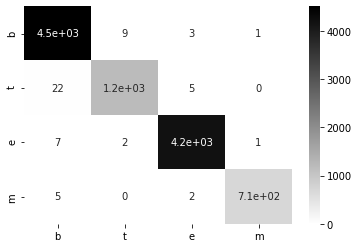

In [204]:
show_cm(train_cm)

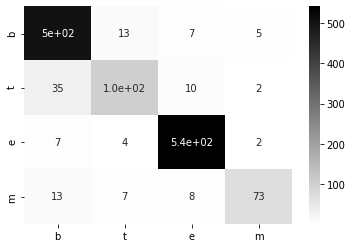

In [205]:
show_cm(test_cm)

## 56. 適合率，再現率，F1スコアの計測

52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [242]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [243]:
print(precision_score(test_t, test_pred, average=None))
print(recall_score(test_t, test_pred, average=None))
print(f1_score(test_t, test_pred, average=None))
print(precision_score(test_t, test_pred, average='micro'))
print(recall_score(test_t, test_pred, average='micro'))
print(f1_score(test_t, test_pred, average='micro'))
print(precision_score(test_t, test_pred, average='macro'))
print(recall_score(test_t, test_pred, average='macro'))
print(f1_score(test_t, test_pred, average='macro'))

[0.90125673 0.81395349 0.95583039 0.8902439 ]
[0.95256167 0.69078947 0.9765343  0.72277228]
[0.92619926 0.74733096 0.96607143 0.79781421]
0.9152923538230885
0.9152923538230885
0.9152923538230885
0.8903211279998021
0.835664429192509
0.8593539647671036


In [244]:
tp = test_cm.diagonal()

In [245]:
fn = test_cm.sum(axis=1) - tp

In [246]:
fp = test_cm.sum(axis=0) - tp

In [247]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_score = 2 * precision * recall / (precision + recall)

In [248]:
micro_precision = tp.sum() / (tp + fp).sum()
micro_recall = tp.sum() / (tp + fn).sum()
micro_f_score = 2 * micro_precision * micro_recall / (micro_precision + micro_recall)
micro_average = np.array([micro_precision, micro_recall, micro_f_score])

In [249]:
macro_precision = precision.mean()
macro_recall = recall.mean()
macro_f_score = 2 * macro_precision * macro_recall / (macro_precision + macro_recall)
macro_average = np.array([macro_precision, macro_recall, macro_f_score])

In [250]:
table = np.array([precision, recall, f_score]).T
table = np.vstack([table, micro_average, macro_average])
pd.DataFrame(
    table,
    index=categories + ['micro average', 'macro average'],
    columns=['precision', 'recall', 'f1 score']
)

,precision,recall,f1 score
b,0.901257,0.952562,0.926199
t,0.813953,0.690789,0.747331
e,0.955830,0.976534,0.966071
m,0.890244,0.722772,0.797814
micro average,0.915292,0.915292,0.915292
macro average,0.890321,0.835664,0.862127


## 57. 特徴量の重みの確認

52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ

In [237]:
def show_weight(directional, n):
    for i, cat in enumerate(categories):
        indices = lr.coef_[i].argsort()[::directional][:n]
        best = np.array(features)[indices]
        weight = lr.coef_[i][indices]
        print(category[categories[i]])
        display(pd.DataFrame([best, weight], index=['features', 'weight'], columns=np.arange(n)+1))

In [238]:
show_weight(-1, 10)

business


,1,2,3,4,5,6,7,8,9,10
features,bank,fed,ukrain,argentina,china,obamacar,ecb,yellen,profit,ipo
weight,1.74466,1.57014,1.55649,1.4771,1.43283,1.42519,1.42189,1.38407,1.37153,1.28616


science and technology


,1,2,3,4,5,6,7,8,9,10
features,facebook,googl,appl,microsoft,climat,tesla,nasa,heartble,gm,fcc
weight,2.58127,2.51863,2.42747,2.22027,2.12589,1.8463,1.79383,1.79305,1.72469,1.61085


entertainment


,1,2,3,4,5,6,7,8,9,10
features,film,kardashian,chris,movi,music,paul,wed,beyonc,star,fan
weight,1.5638,1.45495,1.45236,1.40551,1.40533,1.37556,1.26622,1.19253,1.17549,1.16164


medical


,1,2,3,4,5,6,7,8,9,10
features,ebola,cancer,fda,studi,drug,doctor,brain,health,mer,medic
weight,2.29029,2.14277,2.04471,1.85278,1.78372,1.7012,1.56464,1.56369,1.54942,1.48249


In [239]:
show_weight(1, 10)

business


,1,2,3,4,5,6,7,8,9,10
features,aereo,video,activis,subscript,heartble,ebola,studi,babi,virus,tv
weight,-1.45964,-1.19757,-1.161,-1.09074,-1.08927,-1.01531,-0.98909,-0.9819,-0.949301,-0.909577


science and technology


,1,2,3,4,5,6,7,8,9,10
features,drug,drop,surg,mean,accus,grow,rate,us stock,acquisit,cancer
weight,-0.923433,-0.896985,-0.885598,-0.857227,-0.8089,-0.803811,-0.800683,-0.781684,-0.781417,-0.767713


entertainment


,1,2,3,4,5,6,7,8,9,10
features,googl,china,ceo,recal,scientist,facebook,oil,microsoft,gm,bln
weight,-1.43507,-1.28048,-1.1322,-1.1292,-1.08681,-1.07089,-1.04611,-1.02327,-1.0083,-1.00238


medical


,1,2,3,4,5,6,7,8,9,10
features,gm,deal,facebook,appl,bank,hit,climat,fund,twitter,profit
weight,-0.852715,-0.828509,-0.781987,-0.735705,-0.708522,-0.616807,-0.614581,-0.595892,-0.591555,-0.552596


## 58. 正則化パラメータの変更

ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [240]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [241]:
Cs = np.arange(0.1, 5.1, 0.1)
lrs = [LogisticRegression(C=C, max_iter=1000).fit(train_x, train_t) for C in tqdm(Cs)]

100%|██████████| 50/50 [13:16<00:00, 15.92s/it]


In [252]:
def accuracy(lr, xs, ts):
    ys = lr.predict(xs)
    return (ys == ts).mean()

In [253]:
train_accs = [accuracy(lr, train_x, train_t) for lr in lrs]
valid_accs = [accuracy(lr, valid_x, valid_t) for lr in lrs]
test_accs = [accuracy(lr, test_x, test_t) for lr in lrs]

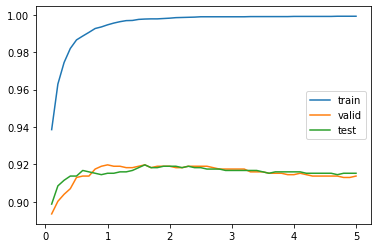

In [255]:
plt.plot(Cs, train_accs, label='train')
plt.plot(Cs, valid_accs, label='valid')
plt.plot(Cs, test_accs, label='test')
plt.legend()

## 59. ハイパーパラメータの探索

学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ

In [256]:
tols = np.logspace(0, 2, 50)
lrs = [LogisticRegression(tol=tol, max_iter=1000).fit(train_x, train_t) for tol in tqdm(tols)]

100%|██████████| 50/50 [03:26<00:00,  4.14s/it]


In [257]:
train_accs = [accuracy(lr, train_x, train_t) for lr in lrs]
valid_accs = [accuracy(lr, valid_x, valid_t) for lr in lrs]
test_accs = [accuracy(lr, test_x, test_t) for lr in lrs]

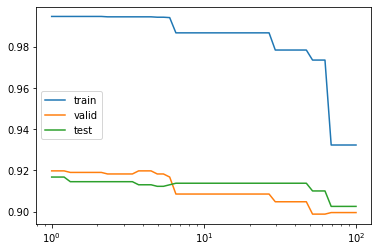

In [258]:
plt.plot(tols, train_accs, label = 'train')
plt.plot(tols, valid_accs, label = 'valid')
plt.plot(tols, test_accs, label = 'test')
plt.xscale('log')
plt.legend()

### Naive Bayes

In [259]:
from sklearn.naive_bayes import MultinomialNB

In [260]:
nb = MultinomialNB()
nb.fit(train_x, train_t)

MultinomialNB()

In [261]:
accuracy(nb, train_x, train_t)

0.943215892053973

In [263]:
accuracy(nb, test_x, test_t)

0.9175412293853074

### Linear SVC

In [265]:
from sklearn.svm import LinearSVC

In [266]:
svc = LinearSVC(C=0.1)
svc.fit(train_x, train_t)

LinearSVC(C=0.1)

In [267]:
accuracy(svc, train_x, train_t)

0.9901611694152923

In [268]:
accuracy(svc, test_x, test_t)

0.9182908545727136